# Wisdom of the Tribe -- Descriptive Statistics
### Justin M. Olds [github.com/jmolds](https://github.com/jmolds)

---
**Project Overview:** The ultimate purpose of this project is to develop a recommendation system for films based the match between a user's film preferences and the preferences of established film critics. This *Wisdom of the Tribes* approach contrasts with *Wisdom of the Masses* approaches provided by many popular websites, such as Metacritic and RottenTomatoes. 

---

**Data:**
* 165,332 critic reviews taken from [metacritic.com](https://www.metacritic.com)
* corresponding to 7689 films
* Reviews were scraped from [metacritic.com](https://www.metacritic.com) based on a list of 19,000 films obtained by scraping search results from [imdb.com](https://www.imdb.com) for the top 500 grossing films (in the US) for every year from 1980 to 2018. 

**Inital exploratory questions:**
* What is the average number of reviews per film, what does the distirbution of total reviews for each films look like?
* What is the average rating for films and what does distibutions of review averages look like?
* What is the average standard deviation of ratings for films, what does this distibution look like, and which films have the hightest amount of variance (largest standard deviation values)? 
* What is the average number of reviews for each credited author and what does this distribution look like? 

In [1]:
%load_ext blackcellmagic

In [17]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.signal import savgol_filter

pd.set_option("precision", 2)
np.set_printoptions(precision=2)

conn = sqlite3.connect("C:/Users/Justin/films_and_reviews2.db")
c = conn.cursor()


In [18]:
film_averages = pd.read_sql_query(
    """
    SELECT film_title, AVG(rating) AS RatingAVG, COUNT(*) as count, film_release_date, film_runtime, film_id
    FROM film INNER JOIN review USING(film_id)
    GROUP BY film_id
""",
    conn,
)
reviews = pd.read_sql_query(
    """
    SELECT *
    FROM review 
""",
    conn,
)
print(
    str(len(reviews))
    + " critic reviews from "
    + str(len(film_averages))
    + " films from 1980 to 2018."
)


165332 critic reviews from 7689 films from 1980 to 2018.


In [19]:
import matplotlib.pylab as pylab

params = {
    "legend.fontsize": "16",
    "figure.figsize": (12, 8),
    "axes.labelsize": "24",
    "axes.titlesize": "26",
    "xtick.labelsize": "18",
    "ytick.labelsize": "18",
    "grid.linewidth": 2,
    "grid.color": "white",
    "axes.labelcolor": ".15",
    "axes.edgecolor": ".15",
    "axes.facecolor": "#dee1ec",
    "legend.edgecolor": "0.15",
    "legend.facecolor": "white",
    "legend.framealpha": 1,
}
pylab.rcParams.update(params)

---
## What is the average number of reviews per film, what does the distirbution of total reviews for each films look like?

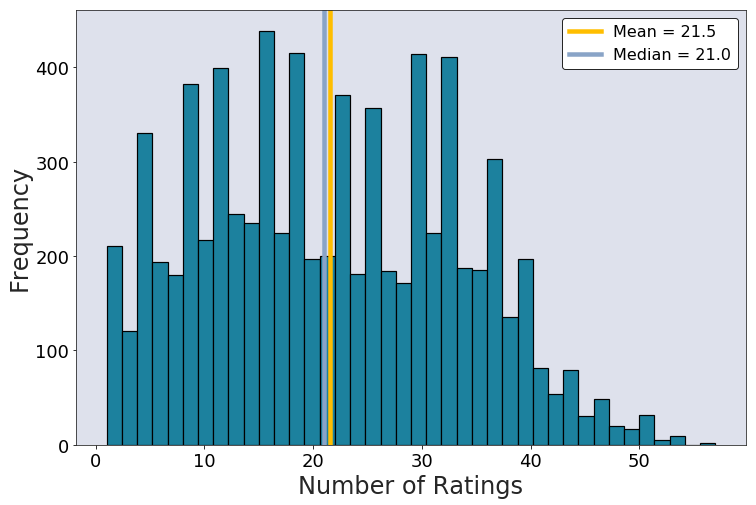

In [20]:
np.set_printoptions(precision=2)
plt.hist(
    film_averages["count"], bins=40, color="#1c819e", edgecolor="black", linewidth=1.2
)
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.axvline(
    x=np.mean(film_averages["count"]),
    color="#ffbe00",
    linewidth=4.5,
    label="Mean = {0:.1f}".format(np.mean(film_averages["count"])),
)
plt.axvline(
    x=np.median(film_averages["count"]),
    color="#89a4c7",
    linewidth=4.5,
    label="Median = {0:.1f}".format(np.median(film_averages["count"])),
)
plt.legend()
plt.show()


---
## What is the average rating for films and what does distibutions of review averages look like?

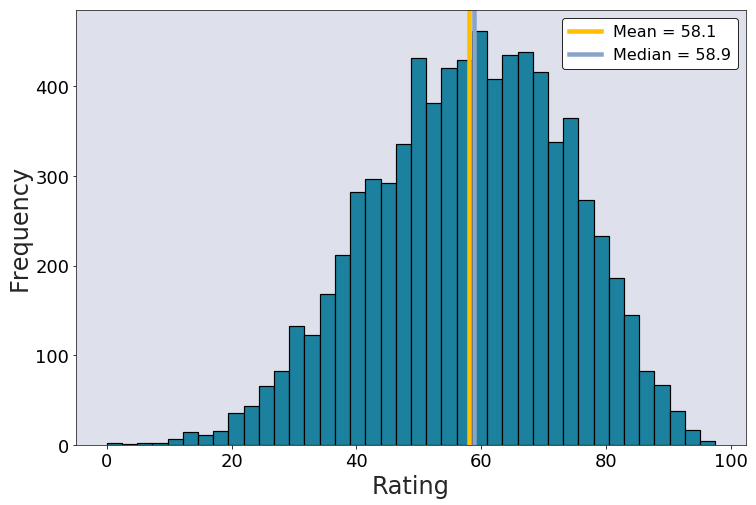

In [21]:
plt.hist(
    film_averages["RatingAVG"],
    bins=40,
    color="#1c819e",
    edgecolor="black",
    linewidth=1.2,
)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.axvline(
    x=np.mean(film_averages["RatingAVG"]),
    color="#ffbe00",
    linewidth=4.5,
    label="Mean = {0:.1f}".format(np.mean(film_averages["RatingAVG"])),
)
plt.axvline(
    x=np.median(film_averages["RatingAVG"]),
    color="#89a4c7",
    linewidth=4.5,
    label="Median = {0:.1f}".format(np.median(film_averages["RatingAVG"])),
)
plt.legend()
plt.show()

---
## What is the average standard deviation of ratings for films, what does this distibution look like, and which films have the hightest amount of variance (largest standard deviation values)?

This analysis requires that films with only a one rating be filtered out. Because films with only a few ratings are not of much interest for the current project, I will filter out films with fewer than 5 ratings.

First things first, rating standard deviation (SD) values need to be computed.

In [22]:
SDvalues = list()
import statistics as stats

for x in film_averages["film_id"]:
    c.execute(
        "SELECT rating FROM review INNER JOIN film USING(film_id) WHERE film_id=?", [x]
    )
    individ_film_reviews = c.fetchall()
    temp_ratings_tuple = tuple([x[0] for x in individ_film_reviews])
    try:
        SDvalues.append(stats.stdev(temp_ratings_tuple))
    except:
        SDvalues.append(None)
film_averages = film_averages.assign(SD=SDvalues)

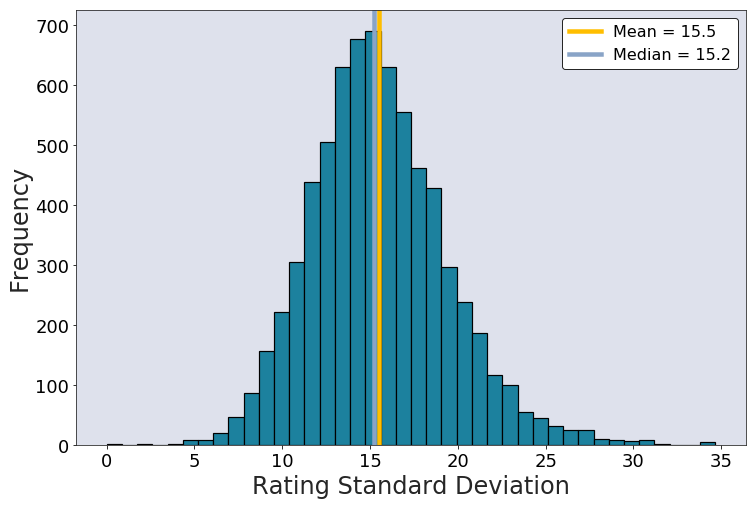

In [23]:
films_filt = film_averages.where(film_averages["count"] > 5)
films_filt = films_filt.dropna(0)
plt.hist(films_filt["SD"], bins=40, color="#1c819e", edgecolor="black", linewidth=1.2)
plt.xlabel("Rating Standard Deviation")
plt.ylabel("Frequency")
plt.axvline(
    x=np.mean(films_filt["SD"]),
    color="#ffbe00",
    linewidth=4.5,
    label="Mean = {0:.1f}".format(np.mean(films_filt["SD"])),
)
plt.axvline(
    x=np.median(films_filt["SD"]),
    color="#89a4c7",
    linewidth=4.5,
    label="Median = {0:.1f}".format(np.median(films_filt["SD"])),
)
plt.legend()
plt.show()


In [24]:
films_filt2 = films_filt.where(films_filt["SD"] > 25)
films_filt2 = films_filt2.dropna(0)
print(
    "Number of films with more than 5 reviews and SD > 30 is {}".format(
        len(films_filt2["SD"])
    )
)
films_filt2[
    ["film_title", "count", "RatingAVG", "SD", "film_release_date"]
].sort_values(by=["SD"], ascending=False)


Number of films with more than 5 reviews and SD > 30 is 122


,film_title,count,RatingAVG,SD,film_release_date
348,Pee-wee's Big Adventure,10.0,54.80,34.66,1985-08-09
632,The Accidental Tourist,10.0,56.80,34.21,1988-12-23
649,They Live,9.0,49.33,34.00,1988-11-04
190,Scarface,7.0,68.29,33.80,1983-12-09
3807,Film Geek,8.0,45.75,31.81,2006-01-13
3830,Nowhere Man,10.0,44.00,30.98,2005-03-11
27,Xanadu,7.0,51.43,30.89,1980-08-08
3118,Dogville,39.0,63.79,30.77,2004-03-26
809,Joe Versus the Volcano,14.0,49.07,30.75,1990-03-09
5312,I'm Still Here,33.0,51.09,30.73,2010-09-10


--- 
## What is the average number of reviews for each credited author and what does this distribution look like?

In [25]:
by_author = pd.read_sql_query(
    """
    SELECT AVG(rating) AS RatingAVG, COUNT(*) as count, author_id, first_name, last_name
    FROM review INNER JOIN author USING(author_id)
    GROUP BY author_id
""",
    conn,
)


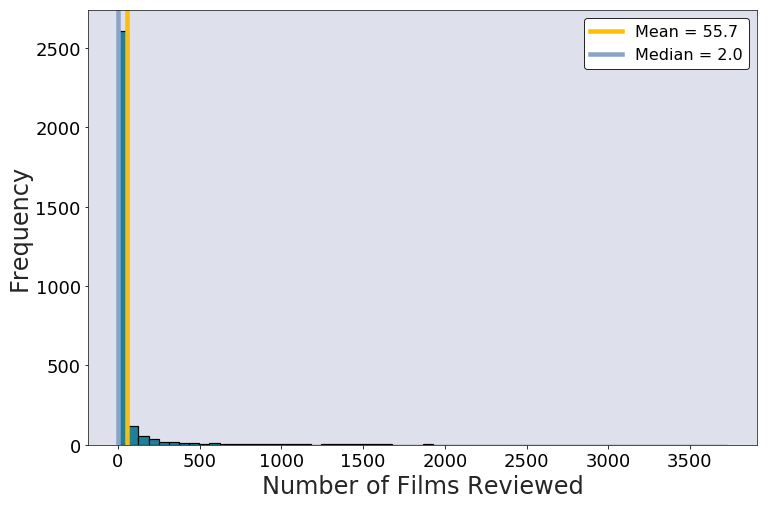

In [26]:
plt.hist(by_author["count"], bins=60, color="#1c819e", edgecolor="black", linewidth=1.2)
plt.xlabel("Number of Films Reviewed")
plt.ylabel("Frequency")
plt.axvline(
    x=np.mean(by_author["count"]),
    color="#ffbe00",
    linewidth=4.5,
    label="Mean = {0:.1f}".format(np.mean(by_author["count"])),
)
plt.axvline(
    x=np.median(by_author["count"]),
    color="#89a4c7",
    linewidth=4.5,
    label="Median = {0:.1f}".format(np.median(by_author["count"])),
)
plt.legend()
plt.show()


As one might expect, some film reviewers have much longer careers than others. Because reviewers with a small number of ratings in the database will not as influential for the purpose of generating tribe ratings, let's look at number of ratings per author distribution with for reviewers with more than 50 ratings. 

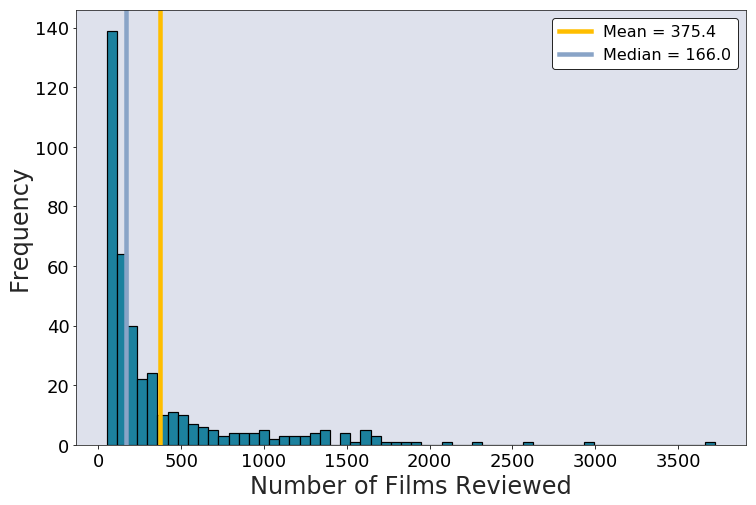

In [27]:
by_author = by_author.where(by_author["count"] > 50)
by_author = by_author.dropna(0)
plt.hist(by_author["count"], bins=60, color="#1c819e", edgecolor="black", linewidth=1.2)
plt.xlabel("Number of Films Reviewed")
plt.ylabel("Frequency")
plt.axvline(
    x=np.mean(by_author["count"]),
    color="#ffbe00",
    linewidth=4.5,
    label="Mean = {0:.1f}".format(np.mean(by_author["count"])),
)
plt.axvline(
    x=np.median(by_author["count"]),
    color="#89a4c7",
    linewidth=4.5,
    label="Median = {0:.1f}".format(np.median(by_author["count"])),
)
plt.legend()
plt.show()


This is encouraging! The database contains a large number of reviewers that rated more than 50 films. 

--- 
## What is the mean standard deviation value for within-reviewer ratings (i.e., ratings from only one reviewer) and what does the distribution look like?

In [28]:
by_author = pd.read_sql_query(
    """
    SELECT AVG(rating) AS RatingAVG, COUNT(*) as count, author_id, first_name, last_name
    FROM review INNER JOIN author USING(author_id)
    GROUP BY author_id
""",
    conn,
)
by_author_filt = by_author.where(by_author["count"] > 5)
by_author_filt = by_author_filt.dropna(0)

SDvalues2 = list()
for x in by_author_filt["author_id"]:
    c.execute(
        "SELECT rating FROM review INNER JOIN author USING(author_id) WHERE author_id=?",
        [x],
    )
    individ_film_reviews = c.fetchall()
    temp_ratings_tuple = tuple([x[0] for x in individ_film_reviews])
    try:
        SDvalues2.append(stats.stdev(temp_ratings_tuple))
    except:
        SDvalues2.append(None)

by_author_filt = by_author_filt.assign(SD=SDvalues2)
by_author_filt = by_author_filt.sort_values(by=["SD"], ascending=False)


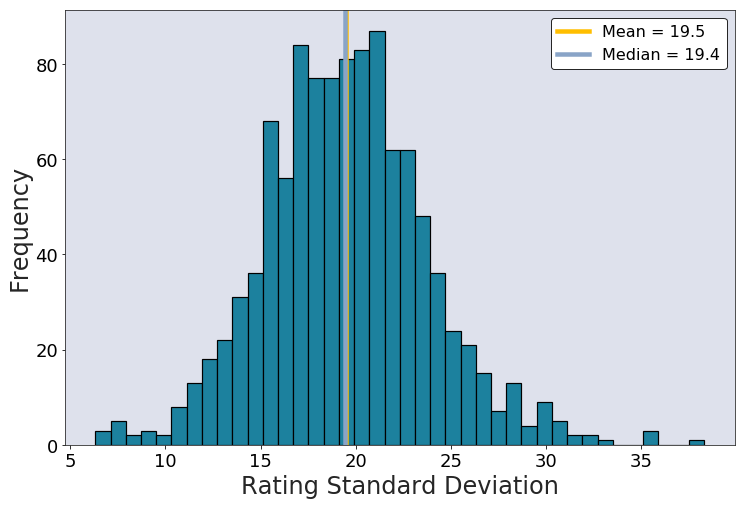

In [29]:
plt.hist(
    by_author_filt["SD"], bins=40, color="#1c819e", edgecolor="black", linewidth=1.2
)
plt.xlabel("Rating Standard Deviation")
plt.ylabel("Frequency")
plt.axvline(
    x=np.mean(by_author_filt["SD"]),
    color="#ffbe00",
    linewidth=4.5,
    label="Mean = {0:.1f}".format(np.mean(by_author_filt["SD"])),
)
plt.axvline(
    x=np.median(by_author_filt["SD"]),
    color="#89a4c7",
    linewidth=4.5,
    label="Median = {0:.1f}".format(np.median(by_author_filt["SD"])),
)
plt.legend()
plt.show()


In [30]:
by_author_filt2 = by_author_filt.where(by_author_filt["SD"] > 30)
by_author_filt2 = by_author_filt2.dropna(0)
print(
    "Number of authors with more than 5 reviews and SD > 30 is {}".format(
        len(by_author_filt2["SD"])
    )
)
print(
    by_author_filt2[
        ["first_name", "last_name", "count", "RatingAVG", "SD"]
    ].sort_values(by=["SD"], ascending=False)
)


Number of authors with more than 5 reviews and SD > 30 is 17
     first_name     last_name  count  RatingAVG     SD
14          Bob      Stephens    8.0      59.50  38.30
2539       Kiva       Reardon    6.0      58.50  35.38
2559      Scout        Tafoya    7.0      69.71  35.29
225     Michael        Blowen   26.0      59.69  35.16
1875   Susannah          Gora    6.0      68.67  33.48
731       Calum         Marsh   32.0      46.03  32.67
1540        Tom      Cappello    8.0      38.12  32.06
2582   Jonathan    L. Fischer    7.0      48.57  31.85
790       Donna         Britt    6.0      58.50  31.40
380     Michael        Sauter   10.0      49.10  30.96
1195      Jimmy        Fowler   11.0      57.27  30.69
235         Rob      Humanick   16.0      54.44  30.56
1476         A.      O. Scott    7.0      35.71  30.47
1515      Other     (Specify)    7.0      56.86  30.32
2000      Kevin       Allison    8.0      61.12  30.28
1389       John  Haslett Cuff    6.0      58.33  30.28
563 